## Module Installation

In [1]:
!pip install catboost -q
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Mounted at /content/drive


## Importing libraries

In [4]:
# Dataframe and Plotting libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn.over_sampling as ovs
import gc
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation

from sklearn.ensemble import *
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
path = '/content/drive/MyDrive/banking-transaction-categoriser/'
seed = 21

## 1. Load the dataset

In [5]:
# Load the files into a Pandas Dataframe
Train = pd.read_csv(path+'Train.csv', parse_dates=['DATE'])
Test = pd.read_csv(path+'Test.csv', parse_dates=['DATE'])
# extra = pd.read_csv(path+'extra_data.csv', parse_dates=['PURCHASED_AT', 'MERCHANT_CATEGORIZED_AT'])

In [6]:
# Let’s observe the shape of our datasets.
print('Train data shape :', Train.shape)
print('Test data shape :', Test.shape)

Train data shape : (57974, 8)
Test data shape : (22625, 8)


In [7]:
# Inspect the training data
Train.head()

,DATE,TRANSACTION DETAILS,Account_NO,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category
0,2014-02-28,NEFT/FDRL401249529/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,15000000.0,Money-Transfer
1,2014-02-28,NEFT/FDRL401249532/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,60000000.0,Money-Transfer
2,2014-02-28,NEFT/FDRL401249534/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,90000000.0,Money-Transfer
3,2014-02-28,NEFT/FDRL401249590/INDIAFORENSIC,84903292,NaN,0.0,10000000.0,100000000.0,Money-Transfer
4,2014-02-28,NEFT/FDRL401249531/INDIAFORENSIC,84903292,NaN,0.0,15000000.0,45000000.0,Money-Transfer


In [8]:
Test.head()

,DATE,TRANSACTION DETAILS,Account_NO,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ID
0,2014-02-28,NEFT/FDRL401249530/INDIAFORENSIC,84903292,NaN,0.00,15000000.0,30000000.00,2014-02-28 00:00:00X3000000000
1,2014-02-28,NEFT/FDRL401249533/INDIAFORENSIC,84903292,NaN,0.00,15000000.0,75000000.00,2014-02-28 00:00:00X7500000000
2,2014-03-08,RTGSCHARGESANDSTAX/RAT,84903292,NaN,28.63,0.0,45000028.63,2014-03-08 00:00:00X4500002863
3,2014-03-08,RTGS/YESBH16068986176/INDFOR,84903292,NaN,15000000.00,0.0,60000028.63,2014-03-08 00:00:00X6000002863
4,2014-03-08,RTGSCHARGESANDSTAX/RAT,84903292,NaN,28.63,0.0,60000057.26,2014-03-08 00:00:00X6000005726


## Missing Values

In [9]:
#check for missing values
percent_missing = Train.isnull().sum() * 100 / len(Train)
missing_value_train = pd.DataFrame({'column_name': Train.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
DATE,DATE,0.000000
TRANSACTION DETAILS,TRANSACTION DETAILS,2.847828
Account_NO,Account_NO,0.000000
CHQ.NO.,CHQ.NO.,99.330734
WITHDRAWAL AMT,WITHDRAWAL AMT,0.000000
DEPOSIT AMT,DEPOSIT AMT,0.000000
BALANCE AMT,BALANCE AMT,0.000000
Category,Category,3.054818


In [10]:
#check for missing values
percent_missing = Test.isnull().sum() * 100 / len(Test)
missing_value_test = pd.DataFrame({'column_name': Test.columns,
                                 'percent_missing': percent_missing})
missing_value_test

,column_name,percent_missing
DATE,DATE,0.000000
TRANSACTION DETAILS,TRANSACTION DETAILS,0.000000
Account_NO,Account_NO,0.000000
CHQ.NO.,CHQ.NO.,99.465193
WITHDRAWAL AMT,WITHDRAWAL AMT,0.000000
DEPOSIT AMT,DEPOSIT AMT,0.000000
BALANCE AMT,BALANCE AMT,0.000000
ID,ID,0.000000


In [11]:
Train = Train.drop(columns = ['CHQ.NO.'])
Test = Test.drop(columns = ['CHQ.NO.'])

In [12]:
 Train = Train.dropna()

## Unique values

In [13]:
# check unique values in dataset
Train.apply(lambda x: len(x.unique()))

DATE                    2311
TRANSACTION DETAILS    29367
Account_NO                10
WITHDRAWAL AMT          5991
DEPOSIT AMT            13147
BALANCE AMT            54546
Category                  21
dtype: int64

In [14]:
# check unique values in dataset
Test.apply(lambda x: len(x.unique()))

DATE                    2136
TRANSACTION DETAILS    12588
Account_NO                10
WITHDRAWAL AMT          4116
DEPOSIT AMT             7326
BALANCE AMT            22624
ID                     22625
dtype: int64

## 2. EDA,Preprocessing and Feature Engineering

### Plots

In [18]:
Train['Category'].nunique()

21

Money-Transfer                      33555
Deposit                             12431
Merchant-Payment                     3160
Cheque-Payment                       1427
Bank Charges                         1122
Cash-Pickup                          1064
Salary and wages                      808
Bill-Payments                         482
Shopping                              119
Cell Phone and Airtime                103
Interest                               70
Loan Repayment                         69
Reversal                               66
Internet and IT Services               22
Insurance                              20
Professional services                  15
Savings and Investments                10
General Purchases                       4
Transport, Travel, and Logistics        2
Donations                               2
Entertainment                           1
Name: Category, dtype: int64


Text(0.5, 0, 'Category')

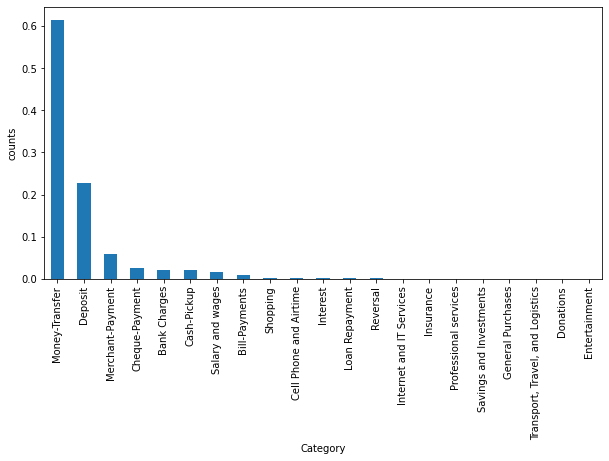

In [19]:
print(Train['Category'].value_counts())
plt.figure(figsize=(10,5))
Train['Category'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Category')

20179201    23339
56986993     9739
84903292     7371
80157410     6577
4969373      4013
28039243     2288
10908140      550
83234289      496
68304903      172
22937010        7
Name: Account_NO, dtype: int64


Text(0.5, 0, 'Account_NO')

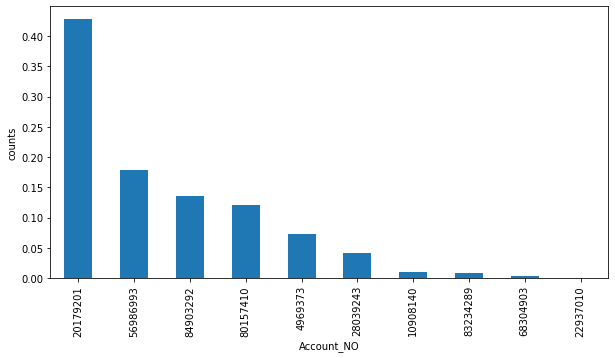

In [20]:
print(Train['Account_NO'].value_counts())
plt.figure(figsize=(10,5))
Train['Account_NO'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Account_NO')

#### Very imbalanced target column

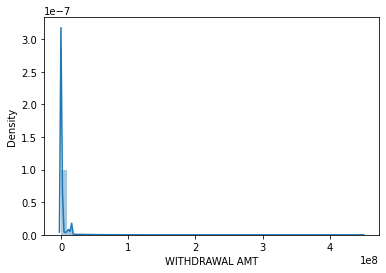

In [21]:
sns.distplot(Train['WITHDRAWAL AMT'])

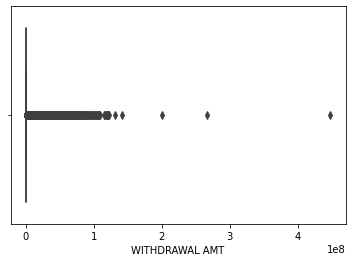

In [22]:
sns.boxplot(Train['WITHDRAWAL AMT'])

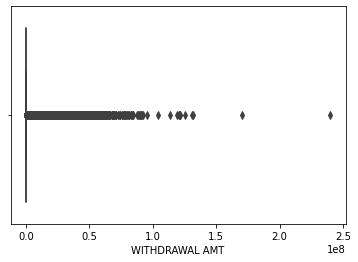

In [23]:
sns.boxplot(Test['WITHDRAWAL AMT'])

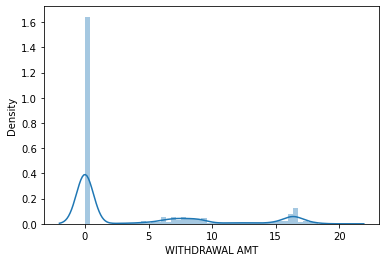

In [24]:
sns.distplot(np.log1p(Train['WITHDRAWAL AMT']))

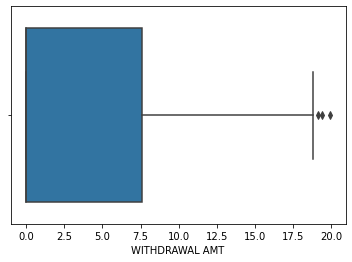

In [25]:
sns.boxplot(np.log1p(Train['WITHDRAWAL AMT']))

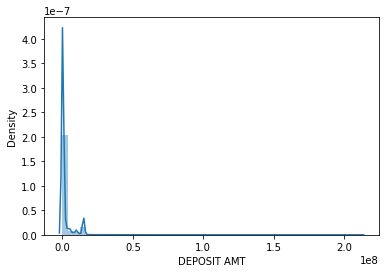

In [26]:
sns.distplot(Train['DEPOSIT AMT'])

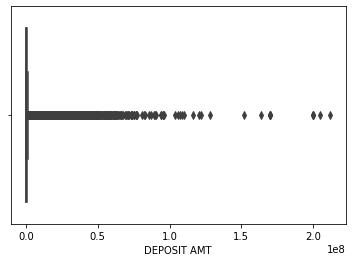

In [27]:
sns.boxplot(Train['DEPOSIT AMT'])

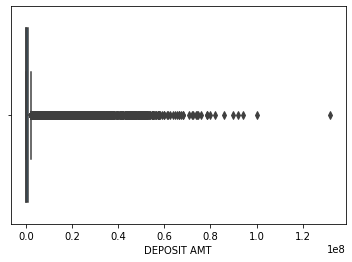

In [28]:
sns.boxplot(Test['DEPOSIT AMT'])

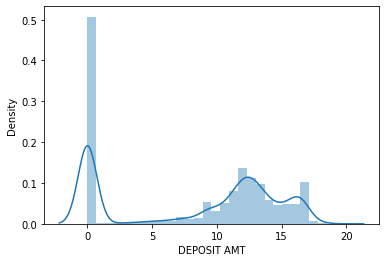

In [29]:
sns.distplot(np.log1p(Train['DEPOSIT AMT']))

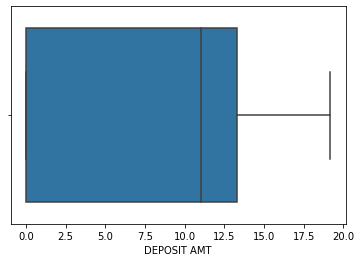

In [30]:
sns.boxplot(np.log1p(Train['DEPOSIT AMT']))

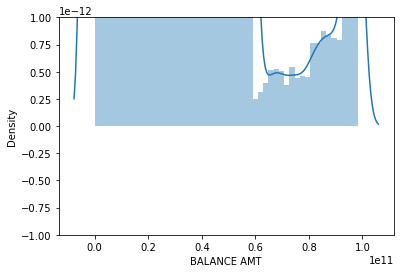

In [31]:
sns.distplot(Train['BALANCE AMT'])

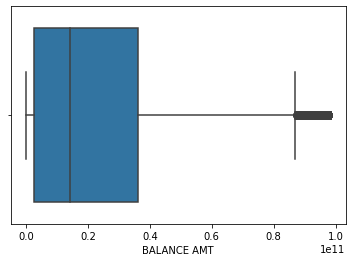

In [32]:
sns.boxplot(Train['BALANCE AMT'])

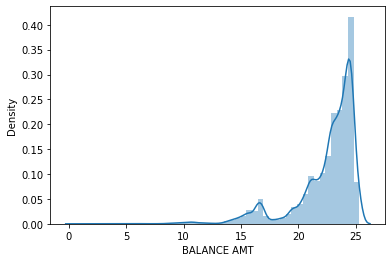

In [33]:
sns.distplot(np.log1p(Train['BALANCE AMT']))

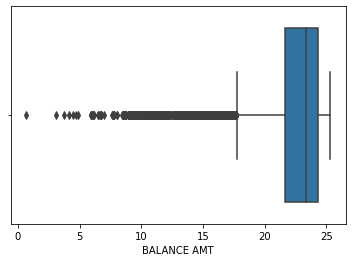

In [34]:
sns.boxplot(np.log1p(Train['BALANCE AMT']))

#### Lets combine all the Train and Test

In [35]:
ID = Test['ID']
Train["train"] = 1
Test["train"] = 0
all_data = pd.concat([Train, Test])
all_data.drop(['ID'], axis=1, inplace=True)

In [36]:
all_data['WITHDRAWAL AMT'] = np.log1p(all_data['WITHDRAWAL AMT'])
all_data['DEPOSIT AMT'] = np.log1p(all_data['DEPOSIT AMT'])

In [37]:
# all_data['WITHDRAWAL AMT'].loc[all_data['WITHDRAWAL AMT'] > 150000000]  = 150000000
# all_data['DEPOSIT AMT'].loc[all_data['DEPOSIT AMT'] > 120000000]  = 120000000

In [38]:
col = ['Account_NO']




for i in col:
    all_data['count_'+i] = all_data[i].map(all_data[i].value_counts())

all_data.head(2)

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO
0,2014-02-28,NEFT/FDRL401249529/INDIAFORENSIC,84903292,0.0,16.523561,15000000.0,Money-Transfer,1,12196
1,2014-02-28,NEFT/FDRL401249532/INDIAFORENSIC,84903292,0.0,16.523561,60000000.0,Money-Transfer,1,12196


In [39]:
def account_bins(x):

    
  one = [20179201]
  two = [56986993]
  three = [84903292]
  four = [80157410]
  five = [4969373]
  six = [28039243]

  seven = [22937010,68304903,83234289,10908140]

  if x in one:
      return 1
  elif x in two:
      return 2
  elif x in three:
      return 3
  elif x in four:
      return 4
  elif x in five:
      return 5
  elif x in six:
      return 6
  elif x in seven:
      return 7

all_data['Account_NO'] = all_data['Account_NO'].apply(account_bins)        
                                       
  

### Feature Engineering

In [40]:
all_data['bef_deposit'] = all_data['BALANCE AMT'] - all_data['DEPOSIT AMT']
all_data['bef_withdrawal'] = all_data['BALANCE AMT'] + all_data['WITHDRAWAL AMT']

In [41]:
all_data['gb_feature_account_blance'] = all_data.groupby(['Account_NO'])['BALANCE AMT'].transform('mean')
all_data['gb_feature_account_balnce_diff'] = all_data['BALANCE AMT'] - all_data['gb_feature_account_blance']

all_data['gb_feature_account_WITHDRAWAL'] = all_data.groupby(['Account_NO'])['WITHDRAWAL AMT'].transform('mean')
all_data['gb_feature_account_WITHDRAWAL_diff'] = all_data['WITHDRAWAL AMT'] - all_data['gb_feature_account_WITHDRAWAL']

all_data['gb_feature_account_DEPOSIT'] = all_data.groupby(['Account_NO'])['DEPOSIT AMT'].transform('mean')
all_data['gb_feature_account_DEPOSI_diff'] = all_data['DEPOSIT AMT'] - all_data['gb_feature_account_DEPOSIT']




In [42]:
domain_categories = {}
all_data["Category"].unique()

array(['Money-Transfer', 'Salary and wages', 'Bank Charges',
       'Cash-Pickup', 'Cheque-Payment', 'Deposit', 'Merchant-Payment',
       'Reversal', 'Savings and Investments', 'Internet and IT Services',
       'Bill-Payments', 'Shopping', 'Interest',
       'Transport, Travel, and Logistics', 'Insurance',
       'Cell Phone and Airtime', 'Entertainment', 'Professional services',
       'General Purchases', 'Donations', 'Loan Repayment', nan],
      dtype=object)

In [43]:
Bank_Charges = all_data[all_data["TRANSACTION DETAILS"].str.contains("fee|tax|charg", case=False)]
domain_categories["Bank_Charges"] = Bank_Charges
print(Bank_Charges.shape)
Bank_Charges.Category.value_counts()


(1668, 17)


Bank Charges     1122
Reversal            3
Bill-Payments       1
Name: Category, dtype: int64

In [44]:
Salary_and_wages = all_data[all_data["TRANSACTION DETAILS"].str.contains("income", case=False)]
domain_categories["Salary_and_wages"] = Salary_and_wages
print(Salary_and_wages.shape)
Salary_and_wages.Category.value_counts()


(1155, 17)


Salary and wages    808
Name: Category, dtype: int64

In [45]:
Cash_Pickup = all_data[all_data["TRANSACTION DETAILS"].str.contains("cashpic|dsb|beat", case=False)]
domain_categories["Cash_Pickup"] = Cash_Pickup
print(Cash_Pickup.shape)
Cash_Pickup.Category.value_counts


(1754, 17)


<bound method IndexOpsMixin.value_counts of 190      Cash-Pickup
192      Cash-Pickup
195      Cash-Pickup
199      Cash-Pickup
201      Cash-Pickup
            ...     
20299            NaN
20308            NaN
20311            NaN
20321            NaN
20324            NaN
Name: Category, Length: 1754, dtype: object>

In [46]:
Cheque_Payment = all_data[all_data["TRANSACTION DETAILS"].str.contains("chqdep", case=False)]
domain_categories["Cheque_Payment"] = Cheque_Payment
print(Cheque_Payment.shape)
Cheque_Payment.Category.value_counts()


(2565, 17)


Cheque-Payment      1427
Merchant-Payment     335
Money-Transfer        36
Name: Category, dtype: int64

In [47]:
Bill_Payments = all_data[all_data["TRANSACTION DETAILS"].str.contains("bbps|billpay", case=False)]
domain_categories["Bill_Payments"] = Bill_Payments
print(Bill_Payments.shape)
print(Bill_Payments["TRANSACTION DETAILS"].unique()[:20])
Bill_Payments.Category.value_counts()


(783, 17)
['BBPSSETTLEMENTDT30/08/' 'BBPSSETTLEMENTDT31/08/'
 'BBPSSETTLEMENTDT01/09/' 'BBPSSETTLEMENTDTD17.10'
 'BBPSSETTLEMENTDTD18.10' 'BBPSSETTLEMENTDTD20.10'
 'BBPSSETTLEMENTDTD21.10' 'BBPSSETTLEMENTFORDT03' 'BBPSSETTLEMENTFORDT04'
 'BBPSSETTLEMENTFORDT05' 'BBPSSETTLEMENTFORDTD0' 'BBPSSETTLEMENTFORDT17'
 'BBPSSETTLEMENTFORDTD1' 'BBPSSETTLEMENTFORDT24' 'BBPSSETTLEMENTFORDT21'
 'BBPSSETTLEMENTFORDT22' 'BBPSSETTLEMENTDTD30DEC' 'BBPSSETTLEMENTDTD17JAN'
 'BBPSSETTLEMENTDTD20JAN' 'BBPSSETTLEMENTDTD21JAN']


Bill-Payments     482
Money-Transfer     96
Name: Category, dtype: int64

In [48]:
Deposit = all_data[(all_data["TRANSACTION DETAILS"].str.contains("cashdep|ica17", case=False))]
print(Deposit.shape[0])
print(Deposit["TRANSACTION DETAILS"].unique()[:20])
Deposit.Category.value_counts()


17157
['CASHDEP/NOIDA/TP' 'CASHDEP/NALASOPARA/900200' 'CASHDEP/RAJOURI/'
 'CASHDEP/BHI-RIICO/' 'CASHDEP/VAPI/' 'CASHDEP/NEW-DELHI/'
 'CASHDEP/KOVVADA/ROCODE-9' 'CASHDEP/DHARWAD/' 'CASHDEP/HAUSKHAS/CASHDE'
 'CASHDEP/BORIVALI/CASHREC' 'CASHDEP/HAUSKHAS/ALOK' 'CASHDEP/THANE-W/'
 'CASHDEP/BOISAR/' 'CASHDEP/NOIDA/TP/ONETIME' 'CASHDEP/VILE-PARLE/'
 'CASHDEP/HAUSKHAS/TP' 'CASHDEP/CAPITOLPT/@CP' 'CASHDEP/THANEWEST/'
 'CASHDEP/NOIDA/TP/RECHARGE' 'CASHDEP/DAMAN/']


Deposit             12431
Bank Charges            3
Merchant-Payment        1
Name: Category, dtype: int64

In [49]:
Internet_and_IT_Services = all_data[all_data["TRANSACTION DETAILS"].str.contains("internet", case=False)]
domain_categories["Internet_and_IT_Services"] = Internet_and_IT_Services
print(Internet_and_IT_Services.shape[0])
print(Internet_and_IT_Services["TRANSACTION DETAILS"].unique())
Internet_and_IT_Services.Category.value_counts()


23
['TIMESINTERNETLIMITED' 'DEOBAZAARINTERNETCOMMER']


Internet and IT Services    22
Name: Category, dtype: int64

In [50]:
Shopping = all_data[all_data["TRANSACTION DETAILS"].str.contains("shopping|onlinepay|purchasing|paymentsfor", case=False)]
domain_categories["Shopping"] = Shopping
print(Shopping.shape[0])
print(Shopping["TRANSACTION DETAILS"].unique())
Shopping.Category.value_counts()


131
['NAAPTOLONLINESHOPPINGP' 'INFINYPOOLONLINEPAYMENT'
 'JEWELCLICKONLINEPAYMENT' 'STAMPPAPERPURCHASING' 'PAYMENTSFOR:9090000405'
 'PAYMENTSFOR:9090000452' 'PAYMENTSFOR:9090000464'
 'PAYMENTSFOR:9090000480' 'PAYMENTSFOR:9090000395'
 'PAYMENTSFOR:9090000421' 'PAYMENTSFOR:9090000433'
 'PAYMENTSFOR:9090000437' 'PAYMENTSFOR:9090000461'
 'PAYMENTSFOR:9090000495' 'PAYMENTSFOR:9090000492'
 'PAYMENTSFOR:9090000506' 'PAYMENTSFOR:9090000577'
 'PAYMENTSFOR:9090000415' 'PAYMENTSFOR:9090000425'
 'PAYMENTSFOR:9090000427' 'PAYMENTSFOR:9090000438'
 'PAYMENTSFOR:9090000542' 'STAMPPAPERPURCHASINGCH'
 'PAYMENTSFOR:9090000505']


Shopping    119
Name: Category, dtype: int64

In [51]:
Interest = all_data[all_data["TRANSACTION DETAILS"].str.contains("int.coll", case=False)]

domain_categories["Interest"] = Interest
print(Interest.shape[0])
print(Interest["TRANSACTION DETAILS"].unique())
Interest.Category.value_counts()


108
['1196428:INT.COLL:01-11-20' '1196428:INT.COLL:01-01-20'
 '1196428:INT.COLL:01-03-20' '1196428:INT.COLL:01-04-20'
 '1196428:INT.COLL:01-05-20' '1196428:INT.COLL:01-07-20'
 '1196428:INT.COLL:01-08-20' '1196428:INT.COLL:01-09-20'
 '409000362497:INT.COLL:01-' '1196711:INT.COLL:01-06-20'
 '1196711:INT.COLL:01-07-20' '1196711:INT.COLL:01-08-20'
 '1196711:INT.COLL:01-09-20' '1196711:INT.COLL:01-11-20'
 '1196711:INT.COLL:01-01-20' '1196711:INT.COLL:01-02-20'
 '1196711:INT.COLL:01-03-20' '1196711:INT.COLL:01-05-20'
 '1196428:INT.COLL:01-10-20' '1196428:INT.COLL:01-12-20'
 '1196428:INT.COLL:01-02-20' '1196428:INT.COLL:01-06-20'
 '1196711:INT.COLL:01-10-20' '1196711:INT.COLL:01-12-20'
 '1196711:INT.COLL:01-04-20' '409000405747:INT.COLL:01-']


Interest    70
Name: Category, dtype: int64

In [52]:
Insurance = all_data[all_data["TRANSACTION DETAILS"].str.contains("insura", case=False)]

domain_categories["Insurance"] = Insurance
print(Insurance.shape[0])
print(Insurance["TRANSACTION DETAILS"].unique())
Insurance.Category.value_counts()


21
['NATIONALINSURANCECOLTD' 'BIRLASUNLIFEINSURANCE' 'NATIONALINSURANCECO'
 'TATAAIGGENERALINSURANC' 'MAXBUPAHEALTHINSURANCE' 'MAXBUPAHELATHINSURACE'
 'NATIONALINSURANCECOMPAN']


Insurance    20
Name: Category, dtype: int64

In [53]:
Cell_Phone_and_Airtime = all_data[all_data["TRANSACTION DETAILS"].str.contains("airtel|vodafone", case=False)]

domain_categories["Cell_Phone_and_Airtime"] = Cell_Phone_and_Airtime
print(Cell_Phone_and_Airtime.shape[0])
print(Cell_Phone_and_Airtime["TRANSACTION DETAILS"].unique())
Cell_Phone_and_Airtime.Category.value_counts()


135
['AIRTELRELATIONSHIP11614' 'AIRTELRELATIONSHIP10951'
 'VODAFONEMOBILESERVICES' 'AIRTELRELATIONSHIP12539'
 'AIRTELRELATIONSHIPNO12' 'AIRTELRELATIONSHIONO12'
 'AIRTELRELATIONSHIONO11' 'VODAFONENO1247161300' 'AIRTELRELATIONSHIONO10'
 'BHARTIAIRTELLLOCALBNKG' '.BHARTIAIRTELLLOCALBNK' 'VODAFONENO.1247161500'
 'VODAFONENO1247161100' 'VODAFONENO1207151000' 'BHARTIAIRTELLTD1095173'
 'BHARTIAIRTELLTD1161438' 'BHARTIAIRTELLTD1152033'
 'BHARTIAIRTELLTD1155147' 'BHARTIAIRTELLTD1155141'
 'BHARTIAIRTELLTD7006279' 'BHARTIAIRTELLTD' 'BHARTIAIRTEL'
 'BHARTIAIRTEL12539330' 'VODAFONE1207191000' 'VODAFONE1247161500'
 'AIRTELRELATIONSHIPNO11' 'AIRTEL' 'AIRTELRELATIONSHIP11520'
 'AIRTELRELATIONSHIP11551' 'BHARTIAIRTELLLDLNCOLL' 'VODAFONE'
 'VODAFONE9899294256' 'VODAFONE9873002188' 'NEFT/000022288318/AIRTEL'
 'AIRTELRELATIONSHIP' 'AIRTELRELANO7025359034' 'VODAFONE1247'
 'VODAFONE1247161300' 'BHARTIAIRTELLLOCBNKBILC']


Cell Phone and Airtime    103
Name: Category, dtype: int64

In [54]:
Loan_Repayment = all_data[all_data["TRANSACTION DETAILS"].str.contains("loan", case=False)]

domain_categories["Loan_Repayment"] = Loan_Repayment
print(Loan_Repayment.shape[0])
print(Loan_Repayment["TRANSACTION DETAILS"].unique())
Loan_Repayment.Category.value_counts()


112
['LOANRECOVERYFOR90900003' 'LOANRECOVERYFOR90900004'
 'LOANRECOVERYFOR90900005']


Loan Repayment    69
Name: Category, dtype: int64

In [55]:
for cat in domain_categories:
    tr_dt = domain_categories[cat]['TRANSACTION DETAILS']
    unq = tr_dt.unique()
    domain_categories[cat] = (len(unq), unq)

    all_data[f"dm-{cat}"] = all_data['TRANSACTION DETAILS'].apply(
        lambda x:x in unq
    ).astype(int)

all_data.head()


,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO,bef_deposit,bef_withdrawal,gb_feature_account_blance,gb_feature_account_balnce_diff,gb_feature_account_WITHDRAWAL,gb_feature_account_WITHDRAWAL_diff,gb_feature_account_DEPOSIT,gb_feature_account_DEPOSI_diff,dm-Bank_Charges,dm-Salary_and_wages,dm-Cash_Pickup,dm-Cheque_Payment,dm-Bill_Payments,dm-Internet_and_IT_Services,dm-Shopping,dm-Interest,dm-Insurance,dm-Cell_Phone_and_Airtime,dm-Loan_Repayment
0,2014-02-28,NEFT/FDRL401249529/INDIAFORENSIC,3,0.0,16.523561,15000000.0,Money-Transfer,1,12196,1.499998e+07,15000000.0,7.242483e+09,-7.227483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0
1,2014-02-28,NEFT/FDRL401249532/INDIAFORENSIC,3,0.0,16.523561,60000000.0,Money-Transfer,1,12196,5.999998e+07,60000000.0,7.242483e+09,-7.182483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0
2,2014-02-28,NEFT/FDRL401249534/INDIAFORENSIC,3,0.0,16.523561,90000000.0,Money-Transfer,1,12196,8.999998e+07,90000000.0,7.242483e+09,-7.152483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0
3,2014-02-28,NEFT/FDRL401249590/INDIAFORENSIC,3,0.0,16.118096,100000000.0,Money-Transfer,1,12196,9.999998e+07,100000000.0,7.242483e+09,-7.142483e+09,4.64617,-4.64617,3.928218,12.189877,0,0,0,0,0,0,0,0,0,0,0
4,2014-02-28,NEFT/FDRL401249531/INDIAFORENSIC,3,0.0,16.523561,45000000.0,Money-Transfer,1,12196,4.499998e+07,45000000.0,7.242483e+09,-7.197483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0


other features

In [56]:
st_dm_cat = [j for i, j in sorted(domain_categories.values())]

def get_bins(x):
    for i, j in enumerate(st_dm_cat):
        if x in j:
            return i
    
    return 11

all_data['TRANSACTION_DETAILS_bins'] = all_data['TRANSACTION DETAILS'].apply(
        get_bins
    )

In [57]:
del Bank_Charges,Cell_Phone_and_Airtime,Insurance,Salary_and_wages,Cash_Pickup,Cheque_Payment,Bill_Payments,Deposit,Internet_and_IT_Services,Shopping,Interest

In [60]:
all_data.shape

(77177, 29)

#### More feature engineering

##### Date features

In [61]:
all_data.DATE = pd.to_datetime(all_data.DATE)

In [62]:
dt_ft = ['day', 'month', 'dayofweek', 'hour', 'quarter']
for ft in dt_ft:
    exec(f'all_data["DATE_{ft}"] = all_data.DATE.dt.{ft}.astype(str)')



In [63]:
def hour_cluster(x):
    x = int(x)
    if (x > 4) and (x <= 8):
        return 0
    elif (x > 8) and (x <= 12 ):
        return 1
    elif (x > 12) and (x <= 16):
        return 2
    elif (x > 16) and (x <= 20) :
        return 3
    elif (x > 20) and (x <= 24):
        return 4
    elif (x <= 4):
        return 5


all_data['DATE_hour'] = all_data['DATE_hour'].apply(hour_cluster)

In [64]:
all_data['TRANSACTION DETAILS WORD'] = all_data['TRANSACTION DETAILS'].str\
    .replace('/', " ").replace("-", " ")
all_data.sample(5)

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO,bef_deposit,bef_withdrawal,gb_feature_account_blance,gb_feature_account_balnce_diff,gb_feature_account_WITHDRAWAL,gb_feature_account_WITHDRAWAL_diff,gb_feature_account_DEPOSIT,gb_feature_account_DEPOSI_diff,dm-Bank_Charges,dm-Salary_and_wages,dm-Cash_Pickup,dm-Cheque_Payment,dm-Bill_Payments,dm-Internet_and_IT_Services,dm-Shopping,dm-Interest,dm-Insurance,dm-Cell_Phone_and_Airtime,dm-Loan_Repayment,TRANSACTION_DETAILS_bins,DATE_day,DATE_month,DATE_dayofweek,DATE_hour,DATE_quarter,TRANSACTION DETAILS WORD
16250,2015-12-25,CASHDEP/KAROLBAGH/,1,0.000000,12.676079,8.507077e+09,Deposit,1,32239,8.507076e+09,8.507077e+09,2.456121e+10,-1.605413e+10,1.390866,-1.390866,11.222157,1.453923,0,0,0,0,0,0,0,0,0,0,0,11,25,12,4,5,4,CASHDEP KAROLBAGH
33514,2016-12-18,CASHDEP/SURAT/,1,0.000000,10.714440,3.965923e+10,Deposit,1,32239,3.965923e+10,3.965923e+10,2.456121e+10,1.509802e+10,1.390866,-1.390866,11.222157,-0.507717,0,0,0,0,0,0,0,0,0,0,0,11,18,12,6,5,4,CASHDEP SURAT
3813,2015-03-16,CR/704008055485/RMCPL07498/,3,7.601402,0.000000,3.063950e+08,Money-Transfer,1,12196,3.063950e+08,3.063950e+08,7.242483e+09,-6.936088e+09,4.646170,2.955233,3.928218,-3.928218,0,0,0,0,0,0,0,0,0,0,0,11,16,3,0,5,1,CR 704008055485 RMCPL07498
19929,2016-02-20,CASHDEP/RAJOURI/,1,0.000000,12.185875,1.329574e+10,Deposit,1,32239,1.329574e+10,1.329574e+10,2.456121e+10,-1.126547e+10,1.390866,-1.390866,11.222157,0.963718,0,0,0,0,0,0,0,0,0,0,0,11,20,2,5,5,1,CASHDEP RAJOURI
9398,2015-08-02,CASHDEP/KADI/,1,0.000000,10.308986,2.396131e+09,Deposit,1,32239,2.396131e+09,2.396131e+09,2.456121e+10,-2.216508e+10,1.390866,-1.390866,11.222157,-0.913171,0,0,0,0,0,0,0,0,0,0,0,11,2,8,6,5,3,CASHDEP KADI


In [65]:
wb_vector = TfidfVectorizer(analyzer='char_wb', ngram_range=(1,9))
X_vect = wb_vector.fit_transform(all_data['TRANSACTION DETAILS'])

X_vect.shape

(77177, 1254447)

In [66]:
n_fts = 5
trunc = TruncatedSVD(n_fts, random_state=21, n_iter=10)

trunc_fts = trunc.fit_transform(X_vect)
for i in range(n_fts):
    all_data[f"transction_detail_truncft_{i+1}"] = trunc_fts[:, i]

all_data.sample()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO,bef_deposit,bef_withdrawal,gb_feature_account_blance,gb_feature_account_balnce_diff,gb_feature_account_WITHDRAWAL,gb_feature_account_WITHDRAWAL_diff,gb_feature_account_DEPOSIT,gb_feature_account_DEPOSI_diff,dm-Bank_Charges,dm-Salary_and_wages,dm-Cash_Pickup,dm-Cheque_Payment,dm-Bill_Payments,dm-Internet_and_IT_Services,dm-Shopping,dm-Interest,dm-Insurance,dm-Cell_Phone_and_Airtime,dm-Loan_Repayment,TRANSACTION_DETAILS_bins,DATE_day,DATE_month,DATE_dayofweek,DATE_hour,DATE_quarter,TRANSACTION DETAILS WORD,transction_detail_truncft_1,transction_detail_truncft_2,transction_detail_truncft_3,transction_detail_truncft_4,transction_detail_truncft_5
13151,2016-11-06,CASHDEP/VIKASMARG/TP/CASH,1,0.0,11.238502,3.693109e+10,NaN,0,32239,3.693109e+10,3.693109e+10,2.456121e+10,1.236988e+10,1.390866,-1.390866,11.222157,0.016345,0,0,0,0,0,0,0,0,0,0,0,11,6,11,6,5,4,CASHDEP VIKASMARG TP CASH,0.166474,-0.222382,-0.06216,-0.063582,-0.054549


In [67]:

# del trunc, trunc_fts
gc.collect()

60

In [68]:
classes = 12
km = KMeans(
        n_clusters=classes, init='random',
        n_init=4, max_iter=1000,
        tol=1e-04, random_state=0
    )
km.fit(X_vect)
ktrans = km.predict(X_vect)
all_data['transction_detail_kmeans'] = ktrans

In [69]:
del km, ktrans, X_vect
gc.collect()

22

In [70]:
for i in range(11):
    all_data['TRANSACTION DETAILS WORD'] = all_data['TRANSACTION DETAILS WORD'].str.replace(str(i), "")
wb_vector = TfidfVectorizer(analyzer='word',ngram_range=(1, 3))
X_vect = wb_vector.fit_transform(all_data['TRANSACTION DETAILS WORD'])

X_vect.shape

(77177, 3936)

In [71]:
n_fts = 4
trunc = TruncatedSVD(n_fts)

trunc_fts = trunc.fit_transform(X_vect)
for i in range(n_fts):
    all_data[f"transction_detail_word_truncft_{i+1}"] = trunc_fts[:, i]

all_data.sample()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO,bef_deposit,bef_withdrawal,gb_feature_account_blance,gb_feature_account_balnce_diff,gb_feature_account_WITHDRAWAL,gb_feature_account_WITHDRAWAL_diff,gb_feature_account_DEPOSIT,gb_feature_account_DEPOSI_diff,dm-Bank_Charges,dm-Salary_and_wages,dm-Cash_Pickup,dm-Cheque_Payment,dm-Bill_Payments,dm-Internet_and_IT_Services,dm-Shopping,dm-Interest,dm-Insurance,dm-Cell_Phone_and_Airtime,dm-Loan_Repayment,TRANSACTION_DETAILS_bins,DATE_day,DATE_month,DATE_dayofweek,DATE_hour,DATE_quarter,TRANSACTION DETAILS WORD,transction_detail_truncft_1,transction_detail_truncft_2,transction_detail_truncft_3,transction_detail_truncft_4,transction_detail_truncft_5,transction_detail_kmeans,transction_detail_word_truncft_1,transction_detail_word_truncft_2,transction_detail_word_truncft_3,transction_detail_word_truncft_4
41028,2017-06-19,NEFT/YESBN15365023366/INDFOR,4,16.523561,0.0,2.201157e+10,Money-Transfer,1,8370,2.201157e+10,2.201157e+10,2.189743e+10,1.141362e+08,6.008609,10.514951,8.583699,-8.583699,0,0,0,0,0,0,0,0,0,0,0,11,19,6,0,5,2,NEFT YESBN INDFOR,0.034671,-0.005403,0.025845,-0.001629,-0.003384,0,9.031695e-07,0.000002,-0.000016,0.000079


In [72]:
del trunc, trunc_fts, X_vect

gc.collect()

46

### Processing

In [73]:
all_data.drop(['DATE'], axis=1, inplace=True)

Label Encoding for categorical columns

In [74]:
cat_fts = [c for c in all_data.select_dtypes(include=['bool', 'object']).columns if c not in ['Category','Account_NO']]
print(cat_fts)
le = LabelEncoder()
for ft in cat_fts:
    all_data[ft] = le.fit_transform(all_data[ft])

['TRANSACTION DETAILS', 'DATE_day', 'DATE_month', 'DATE_dayofweek', 'DATE_quarter', 'TRANSACTION DETAILS WORD']


In [75]:
all_data = pd.get_dummies(data=all_data, columns=['Account_NO'])


In [76]:
all_data.head()

,TRANSACTION DETAILS,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,train,count_Account_NO,bef_deposit,bef_withdrawal,gb_feature_account_blance,gb_feature_account_balnce_diff,gb_feature_account_WITHDRAWAL,gb_feature_account_WITHDRAWAL_diff,gb_feature_account_DEPOSIT,gb_feature_account_DEPOSI_diff,dm-Bank_Charges,dm-Salary_and_wages,dm-Cash_Pickup,dm-Cheque_Payment,dm-Bill_Payments,dm-Internet_and_IT_Services,dm-Shopping,dm-Interest,dm-Insurance,dm-Cell_Phone_and_Airtime,dm-Loan_Repayment,TRANSACTION_DETAILS_bins,DATE_day,DATE_month,DATE_dayofweek,DATE_hour,DATE_quarter,TRANSACTION DETAILS WORD,transction_detail_truncft_1,transction_detail_truncft_2,transction_detail_truncft_3,transction_detail_truncft_4,transction_detail_truncft_5,transction_detail_kmeans,transction_detail_word_truncft_1,transction_detail_word_truncft_2,transction_detail_word_truncft_3,transction_detail_word_truncft_4,Account_NO_1,Account_NO_2,Account_NO_3,Account_NO_4,Account_NO_5,Account_NO_6,Account_NO_7
0,29123,0.0,16.523561,15000000.0,Money-Transfer,1,12196,1.499998e+07,15000000.0,7.242483e+09,-7.227483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0,11,20,4,4,5,0,1344,0.100804,-0.016238,0.155537,0.001464,-0.006472,0,-0.000007,-0.000097,-0.000235,0.002341,0,0,1,0,0,0,0
1,29126,0.0,16.523561,60000000.0,Money-Transfer,1,12196,5.999998e+07,60000000.0,7.242483e+09,-7.182483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0,11,20,4,4,5,0,1344,0.101601,-0.016371,0.156762,0.001476,-0.006528,0,-0.000007,-0.000097,-0.000235,0.002341,0,0,1,0,0,0,0
2,29128,0.0,16.523561,90000000.0,Money-Transfer,1,12196,8.999998e+07,90000000.0,7.242483e+09,-7.152483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0,11,20,4,4,5,0,1344,0.102049,-0.016463,0.157287,0.001459,-0.006523,0,-0.000007,-0.000097,-0.000235,0.002341,0,0,1,0,0,0,0
3,29129,0.0,16.118096,100000000.0,Money-Transfer,1,12196,9.999998e+07,100000000.0,7.242483e+09,-7.142483e+09,4.64617,-4.64617,3.928218,12.189877,0,0,0,0,0,0,0,0,0,0,0,11,20,4,4,5,0,1344,0.100918,-0.016264,0.155778,0.001462,-0.006522,0,-0.000007,-0.000097,-0.000235,0.002341,0,0,1,0,0,0,0
4,29125,0.0,16.523561,45000000.0,Money-Transfer,1,12196,4.499998e+07,45000000.0,7.242483e+09,-7.197483e+09,4.64617,-4.64617,3.928218,12.595343,0,0,0,0,0,0,0,0,0,0,0,11,20,4,4,5,0,1344,0.101799,-0.016450,0.157030,0.001452,-0.006581,0,-0.000007,-0.000097,-0.000235,0.002341,0,0,1,0,0,0,0


## Statistical Information

In [78]:
num_cols = ['DEPOSIT AMT','BALANCE AMT','bef_deposit','bef_withdrawal']
def add_stats(data, feats):
    
    before_ = data.shape[1]
    cols = feats
    data['f_min']   = data[cols].fillna(0).min(axis = 1)
    data['f_max']   = data[cols].fillna(0).max(axis = 1)
    data['f_mean']  = data[cols].fillna(0).mean(axis = 1)
    data['f_sd']    = data[cols].fillna(0).std(axis = 1)
    data['f_median']= data[cols].fillna(0).median(axis = 1)
    data['f_sum']   = data[cols].fillna(0).sum(axis = 1)
    data['f_skew']  = data[cols].fillna(0).skew(axis=1)

    after_ = data.shape[1]
    new_cols = data.iloc[:,before_:after_].columns.tolist()
    
    return data, new_cols

Separate train and test from all_data

In [81]:
train_df = all_data[all_data["train"] == 1].drop(["train"], axis=1)
test_df = all_data[all_data["train"] == 0].drop(["train", 'Category'], axis=1)

In [82]:
print("Train: ", train_df.shape)
print("Test: ", test_df.shape)

Train:  (54552, 49)
Test:  (22625, 48)


## 3. Feature Selection



In [83]:
## modeling

train_df['Category'] = le.fit_transform(train_df['Category'])
cat_map = dict(zip(range(len(le.classes_)) , le.classes_))

cat_map

{0: 'Bank Charges',
 1: 'Bill-Payments',
 2: 'Cash-Pickup',
 3: 'Cell Phone and Airtime',
 4: 'Cheque-Payment',
 5: 'Deposit',
 6: 'Donations',
 7: 'Entertainment',
 8: 'General Purchases',
 9: 'Insurance',
 10: 'Interest',
 11: 'Internet and IT Services',
 12: 'Loan Repayment',
 13: 'Merchant-Payment',
 14: 'Money-Transfer',
 15: 'Professional services',
 16: 'Reversal',
 17: 'Salary and wages',
 18: 'Savings and Investments',
 19: 'Shopping',
 20: 'Transport, Travel, and Logistics'}

In [84]:
main_cols = train_df.columns.difference([
    'Category', 
    # 'TRANSACTION DETAILS', 'TRANSACTION DETAILS WORD'
    
'DATE_hour','dm-Bank_Charges', 'dm-Salary_and_wages', 'dm-Cash_Pickup',
       'dm-Cheque_Payment', 'dm-Bill_Payments', 'dm-Internet_and_IT_Services',
       'dm-Shopping', 'dm-Interest', 'dm-Insurance',
       'dm-Cell_Phone_and_Airtime', 'dm-Loan_Repayment',
    
])

X = train_df[main_cols] 
y = train_df['Category']

test = test_df[main_cols]

X.shape, test.shape

((54552, 36), (22625, 36))

Apply SMOTE to overcome the imbalance

In [85]:
print(y.value_counts().to_dict())

{14: 33555, 5: 12431, 13: 3160, 4: 1427, 0: 1122, 2: 1064, 17: 808, 1: 482, 19: 119, 3: 103, 10: 70, 12: 69, 16: 66, 11: 22, 9: 20, 15: 15, 18: 10, 8: 4, 20: 2, 6: 2, 7: 1}


In [86]:
from imblearn import under_sampling as uns 


stra1 = {14: 4000, 5: 3000, 13: 1200, 4: 1000, 0: 900,
        2: 850, 17: 700, 1: 400, 19: 119, 3: 103,
        10: 70, 12: 69, 16: 66, 11: 22, 9: 20, 15: 15,
        18: 10, 8: 4, 20: 2, 6: 2, 7: 1}

stra2 = {14: 4000, 5: 3000, 13: 1200, 4: 1000, 0: 900,
        2: 850, 17: 700, 1: 400, 19: 130, 3: 110,
        10: 100, 12: 80, 16: 80, 11: 50, 9: 45, 15: 40,
        18: 30, 8: 20, 20: 15, 6: 15, 7: 10}
        
undersample = uns.RandomUnderSampler(sampling_strategy=stra1, random_state=0)
X, y = undersample.fit_resample(X, y)

oversample = ovs.RandomOverSampler(sampling_strategy=stra2, random_state=0)
X, y = oversample.fit_resample(X, y)

X.shape

(12775, 36)

In [87]:

# class for training more than one models and averging the results
class My_model:
    def __init__(self, models):
        self.models = models

    def fit_eval_pred(self, X, y, eval_set, val, test, verbose=True):
        results_eval = []
        results_test = []
        for i, model in enumerate(self.models):
            if verbose:
                print(f"[Training]............................... Model_{i+1}")
            st = time.time()
            try:
                model.fit(X, y, eval_set=eval_set, verbose=False)
            except Exception as e:
                model.fit(X, y)
            if verbose:
                print(f"[Prediction]............................. Model_{i+1}")
            p = model.predict_proba(val)
            results_eval.append(p)
            results_test.append(model.predict_proba(test))
            if verbose:
                print(f"Log loss = {log_loss(eval_set[0][1], p)}", end=" "*6)
                print(f"Time {time.time() - st :.2f}sec")

        results_eval = np.mean(results_eval, axis=0)
        results_test = np.mean(results_test, axis=0)

        return results_eval, results_test


In [100]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


# custom function gives models 
def get_models(seed=21):

    cat_params = {"iterations":1000, "verbose":100, "random_state":seed,
            'use_best_model':True, 'early_stopping_rounds':100, 
        #     "learning_rate":0.09,
            }
    lgb_params = {'learning_rate':0.01, 'n_estimators':10000, 'random_state':seed,
            'early_stopping_round':100, 'verbose':-1, 'subsample':.8, 'colsample_bytree':0.6}


    _models = [
            CatBoostClassifier(**cat_params, task_type='GPU'),   
            LGBMClassifier(**lgb_params)
    ]
    return _models


In [101]:
from sklearn.model_selection import StratifiedKFold

results = []
ns = 5
tot = []


skf = StratifiedKFold(n_splits=ns, random_state=seed, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(100*"-")
    print(f"Fold-{fold+1}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    main_model = My_model(get_models())
    pred_train, pred_test = main_model.fit_eval_pred(X_train, y_train, [(X_test, y_test)], X_test, test)
    try:
      loss = log_loss(y_test, pred_train)
      print(f"log loss = {loss}")
      tot += [loss]
    except Exception as e:
      print(e)
    results.append(pred_test)

    print(100*"-")
    print("\n\n")

print(f"Average log loss = {sum(tot) / len(tot)}")

----------------------------------------------------------------------------------------------------
Fold-1
[Training]............................... Model_1
[Prediction]............................. Model_1
Log loss = 0.007438928529922189      Time 23.51sec
[Training]............................... Model_2
[Prediction]............................. Model_2
Log loss = 0.010895704265659516      Time 100.99sec
log loss = 0.00800184558768036
----------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------
Fold-2
[Training]............................... Model_1
[Prediction]............................. Model_1
Log loss = 0.014788429125742597      Time 11.08sec
[Training]............................... Model_2
[Prediction]............................. Model_2
Log loss = 0.012389940836196453      Time 119.84sec
log loss = 0.00999773834378715
------------

In [102]:
preds = np.mean(results, axis=0)
preds.shape

(22625, 21)

In [103]:
sub = pd.DataFrame(np.round(preds, 4), columns=cat_map.values(), index=ID)
sub.drop(columns="Entertainment", inplace=True)
sub.to_csv("submission2.csv")
sub.head()

,Bank Charges,Bill-Payments,Cash-Pickup,Cell Phone and Airtime,Cheque-Payment,Deposit,Donations,General Purchases,Insurance,Interest,Internet and IT Services,Loan Repayment,Merchant-Payment,Money-Transfer,Professional services,Reversal,Salary and wages,Savings and Investments,Shopping,"Transport, Travel, and Logistics"
ID,,,,,,,,,,,,,,,,,,,,
2014-02-28 00:00:00X3000000000,0.0000,0.0000,0.0000,0.0,0.0000,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.9996,0.0,0.0001,0.0001,0.0,0.0000,0.0
2014-02-28 00:00:00X7500000000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.9996,0.0,0.0001,0.0001,0.0,0.0000,0.0
2014-03-08 00:00:00X4500002863,0.9931,0.0001,0.0001,0.0,0.0002,0.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0003,0.0013,0.0,0.0035,0.0006,0.0,0.0002,0.0
2014-03-08 00:00:00X6000002863,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.9998,0.0,0.0000,0.0001,0.0,0.0000,0.0
2014-03-08 00:00:00X6000005726,0.9930,0.0001,0.0001,0.0,0.0002,0.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0003,0.0013,0.0,0.0035,0.0006,0.0,0.0002,0.0
